In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import csv
import shutil
import os
from collections import *
from PIL import Image,ImageOps
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow.keras.layers as KL
from tensorflow.keras.models import Sequential
import pywt
import seaborn as sn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score
import tensorflow as tf

In [ ]:
#train data
! wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip -P data
! unzip data/GTSRB_Final_Training_Images.zip -d data 
#test data
! wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip -P data
! unzip data/GTSRB_Final_Test_Images.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/GTSRB/Final_Test/Images/07632.ppm  
  inflating: data/GTSRB/Final_Test/Images/07633.ppm  
  inflating: data/GTSRB/Final_Test/Images/07634.ppm  
  inflating: data/GTSRB/Final_Test/Images/07635.ppm  
  inflating: data/GTSRB/Final_Test/Images/07636.ppm  
  inflating: data/GTSRB/Final_Test/Images/07637.ppm  
  inflating: data/GTSRB/Final_Test/Images/07638.ppm  
  inflating: data/GTSRB/Final_Test/Images/07639.ppm  
  inflating: data/GTSRB/Final_Test/Images/07640.ppm  
  inflating: data/GTSRB/Final_Test/Images/07641.ppm  
  inflating: data/GTSRB/Final_Test/Images/07642.ppm  
  inflating: data/GTSRB/Final_Test/Images/07643.ppm  
  inflating: data/GTSRB/Final_Test/Images/07644.ppm  
  inflating: data/GTSRB/Final_Test/Images/07645.ppm  
  inflating: data/GTSRB/Final_Test/Images/07646.ppm  
  inflating: data/GTSRB/Final_Test/Images/07647.ppm  
  inflating: data/GTSRB/Final_Test/Images/07648.ppm  
  inflating: data/GTSRB/Final_T

In [ ]:
datadir= '/content/data/GTSRB/Final_Training/Images'
height = 30
width = 30
channels = 3
num_classes = 43
n_inputs = height * width*channels
labels=[]
training_data=[]

In [ ]:
#grayscale 
for c in range(0, 43):
  filename = os.path.join(datadir, format(c, '05d'), 'GT-' + format(c, '05d') + '.csv')
  newrows = []
  with open(filename) as f:
    reader = csv.reader(f, delimiter=';')
    next(reader)
    for row in reader:
      filename = row[0]
      im = cv2.imread(os.path.join(datadir, format(c, '05d'), filename),cv2.IMREAD_GRAYSCALE)
      image_from_array = Image.fromarray(im, 'L')
      size_image = image_from_array.resize((height, width))
      training_data.append(np.array(size_image))
      labels.append(c)

In [ ]:
x_train=np.array(training_data)
x_train= x_train/255.0

y_train=np.array(labels)
y_train = to_categorical(y_train, num_classes)

In [ ]:
X_train,X_valid,Y_train,Y_valid = train_test_split(x_train,y_train,test_size = 0.3,random_state=0)

In [ ]:
X_train.shape

(27446, 30, 30)

In [ ]:
#normal grayscale
with tf.device('/gpu:0'):
  ## Model
  model = Sequential()
  model.add(KL.LSTM(128,input_shape=X_train.shape[1:]))
  model.add(KL.Dense(num_classes, activation="softmax"))

  model.summary()
  model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["acc"])
  model.fit(X_train, Y_train, epochs=15)
  test_loss, test_acc = model.evaluate(X_valid, Y_valid)
  print("Loss: {0} - Acc: {1}".format(test_loss, test_acc))

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 128)               81408     
_________________________________________________________________
dense_9 (Dense)              (None, 43)                5547      
Total params: 86,955
Trainable params: 86,955
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
858/858 [==============================] - 24s 28ms/step - loss: 2.7891 - acc: 0.2220
Epoch 2/15
858/858 [==============================] - 24s 28ms/step - loss: 1.2430 - acc: 0.6240
Epoch 3/15
858/858 [==============================] - 24s 28ms/step - loss: 0.6724 - acc: 0.7990
Epoch 4/15
858/858 [==============================] - 24s 28ms/step - loss: 0.4382 - acc: 0.8668
Epoch 5/15
858/858 [==============================] - 24s 28ms/step - loss: 0.3219 - acc: 0.9033
Epoch 6/15
858/858 [======

In [ ]:
datadir= '/content/data/GTSRB/Final_Training/Images'
height = 30
width = 30
channels = 3
num_classes = 43
n_inputs = height * width*channels
labels=[]
training_data=[]
#grayscale wavelet
for c in range(0, 43):
  filename = os.path.join(datadir, format(c, '05d'), 'GT-' + format(c, '05d') + '.csv')
  newrows = []
  with open(filename) as f:
    reader = csv.reader(f, delimiter=';')
    next(reader)
    for row in reader:
      filename = row[0]
      im = Image.open(os.path.join(datadir, format(c, '05d'), filename))
      img=im.resize((60,60))
      img = ImageOps.grayscale(img)
      coeffs = pywt.dwt2(img, 'haar',mode='periodization')
      ca, (ch, cv, cd) = coeffs
      #ca=np.reshape(ca, ca.shape + (1,))
      training_data.append(ca)
      labels.append(c)
x_train=np.array(training_data)
x_train= x_train/255.0

y_train=np.array(labels)
y_train = to_categorical(y_train, num_classes)
X_train,X_valid,Y_train,Y_valid = train_test_split(x_train,y_train,test_size = 0.3,random_state=0)

In [ ]:
#wavelet grayscale
with tf.device('/gpu:0'):
  ## Model
  model = Sequential()
  model.add(KL.LSTM(128,input_shape=X_train.shape[1:]))
  model.add(KL.Dense(num_classes, activation="softmax"))

  model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["acc"])
  hist=model.fit(X_train, Y_train, epochs=10,batch_size=32,validation_data=(X_valid, Y_valid))


Epoch 1/10
858/858 [==============================] - 27s 32ms/step - loss: 2.8729 - acc: 0.2028 - val_loss: 2.2372 - val_acc: 0.3452
Epoch 2/10
858/858 [==============================] - 27s 31ms/step - loss: 1.3560 - acc: 0.5894 - val_loss: 0.8970 - val_acc: 0.7291
Epoch 3/10
858/858 [==============================] - 27s 31ms/step - loss: 0.6641 - acc: 0.8007 - val_loss: 0.5968 - val_acc: 0.8228
Epoch 4/10
858/858 [==============================] - 27s 31ms/step - loss: 0.3996 - acc: 0.8828 - val_loss: 0.3619 - val_acc: 0.8913
Epoch 5/10
858/858 [==============================] - 27s 31ms/step - loss: 0.2842 - acc: 0.9164 - val_loss: 0.2737 - val_acc: 0.9202
Epoch 6/10
858/858 [==============================] - 27s 31ms/step - loss: 0.2033 - acc: 0.9416 - val_loss: 0.2137 - val_acc: 0.9424
Epoch 7/10
858/858 [==============================] - 27s 31ms/step - loss: 0.1692 - acc: 0.9509 - val_loss: 0.1816 - val_acc: 0.9526
Epoch 8/10
858/858 [==============================] - 27s 31ms

In [ ]:
#test
! wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip -P data
! unzip data/GTSRB_Final_Test_GT.zip -d /content/data/GTSRB/Final_Test/Images

--2020-11-24 11:00:32--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99620 (97K) [application/zip]
Saving to: ‘data/GTSRB_Final_Test_GT.zip’

GTSRB_Final_Test_GT 100%[===================>]  97.29K   424KB/s    in 0.2s    

2020-11-24 11:00:33 (424 KB/s) - ‘data/GTSRB_Final_Test_GT.zip’ saved [99620/99620]

Archive:  data/GTSRB_Final_Test_GT.zip
  inflating: /content/data/GTSRB/Final_Test/Images/GT-final_test.csv  


In [ ]:
#grayscale wavelet
height = 30
width = 30
channels = 3
num_classes = 43
n_inputs = height * width*channels
test_labels=[]
test_data=[]
datadir='/content/data/GTSRB/Final_Test/Images'
filename = "/content/data/GTSRB/Final_Test/Images/GT-final_test.csv"
with open(filename) as f:
  reader = csv.reader(f, delimiter=';')
  next(reader)
  for row in reader:
    filename = row[0]
    im = Image.open(os.path.join(datadir, filename))
    img=im.resize((60,60))
    img = ImageOps.grayscale(img)
    coeffs = pywt.dwt2(img, 'haar',mode='periodization')
    ca, (ch, cv, cd) = coeffs
    #ca=np.reshape(ca, ca.shape + (1,))
    test_data.append(ca)
    test_labels.append(int(row[7]))

In [ ]:
x_test=np.array(test_data)
x_test= x_test/255.0
y_test=np.array(test_labels)
y_test = to_categorical(y_test, num_classes)


In [ ]:
predicts = np.argmax(model.predict(x_test), axis=1) 
pred = to_categorical(predicts, num_classes)
accuracy_score(y_test,pred)

0.8794140934283452

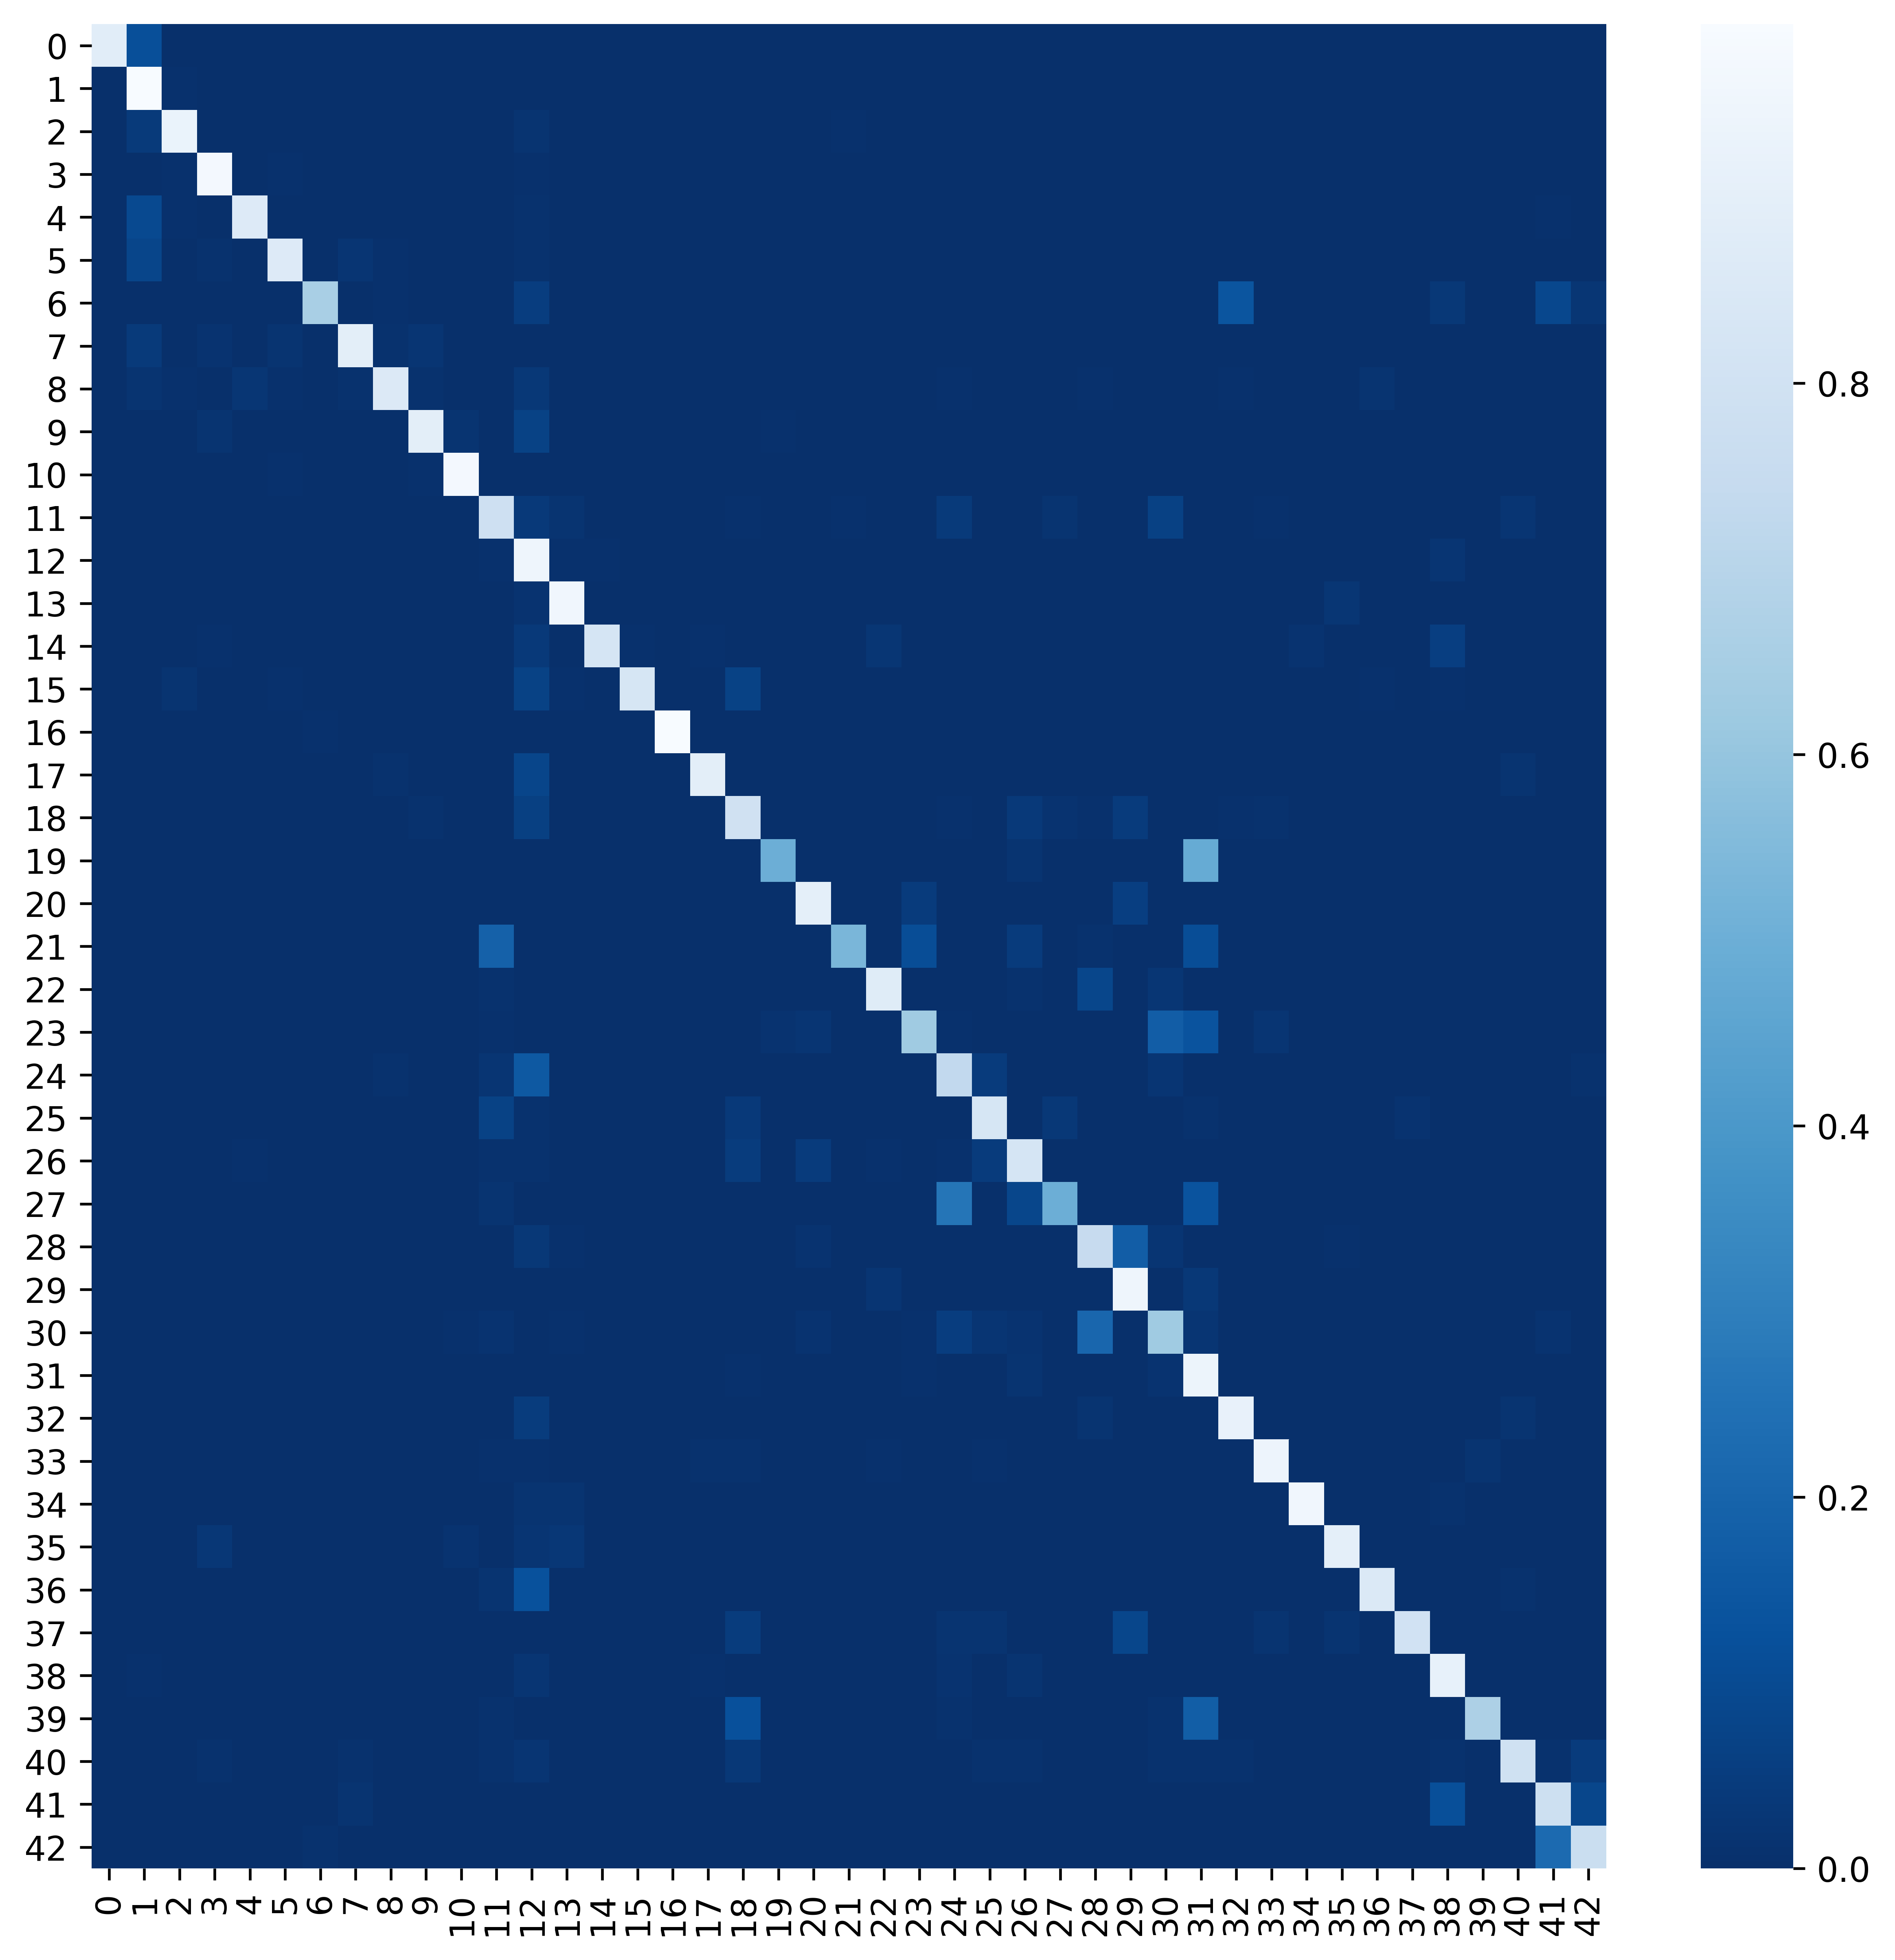

In [ ]:
cm=confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1))
cm = cm/cm.sum(axis=1)[:,np.newaxis]
plt.figure(figsize = (10,10),dpi=600)
sn.heatmap(cm,cmap="Blues_r")


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               81408     
_________________________________________________________________
dense (Dense)                (None, 43)                5547      
Total params: 86,955
Trainable params: 86,955
Non-trainable params: 0
_________________________________________________________________


In [ ]:
acc=hist.history['acc']
valacc=hist.history['val_acc']

In [ ]:
for i in range(0,10):
  acc[i]=acc[i]*100
  valacc[i]=valacc[i]*100

In [ ]:
plt.figure(figsize = (10,10),dpi=600)
plt.plot(acc)
plt.plot(valacc)
plt.title('model accuracy')
plt.ylabel('accuracy(in %)')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [ ]:
loss=[]
valloss=[]
for i in range(0,10):
  loss.append(100 - acc[i])
  valloss.append(100-valacc[i])

In [ ]:
plt.figure(figsize = (10,10),dpi=600)
plt.plot(loss)
plt.plot(valloss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
#precision_score(y_test.argmax(axis=1), pred.argmax(axis=1))
print("Precision")
precision_score(y_test, pred,average='weighted')


Precision


0.8862710246609395

In [ ]:
print("Recall")
recall_score(y_test, pred,average='weighted')

Recall


0.8827395091053049

In [ ]:
print("F1")
f1_score(y_test, pred,average='weighted')

F1


0.8825626246602286

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
roc_curve(y_test.argmax(axis=1), pred.argmax(axis=1))

ValueError: ignored